# Multiple Linear Regression Assignment

## Problem Statement 

Using Multiple Linear Regression in order to model the deman for shared bikes. Need to understand the factors affecting the demand for the shared bbikes in the American Market.

It answers:

- Which variables are significant in predicting the demand for shared bikes
- How well those variables describe the bike demand

Understanding this will help in coming up with a business strategy to meet the demand levels and the cutomer's expectation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)

## Step 1: Read and Understand the data

### Inpsect the data

In [3]:
# Read the data and do a preliminary inspection
bikes = pd.read_csv("../data/day.csv")
bikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
# check how much data is given
bikes.shape

(730, 16)

In [5]:
# check the data types
bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [6]:
# check the spread of the numerical data
bikes.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


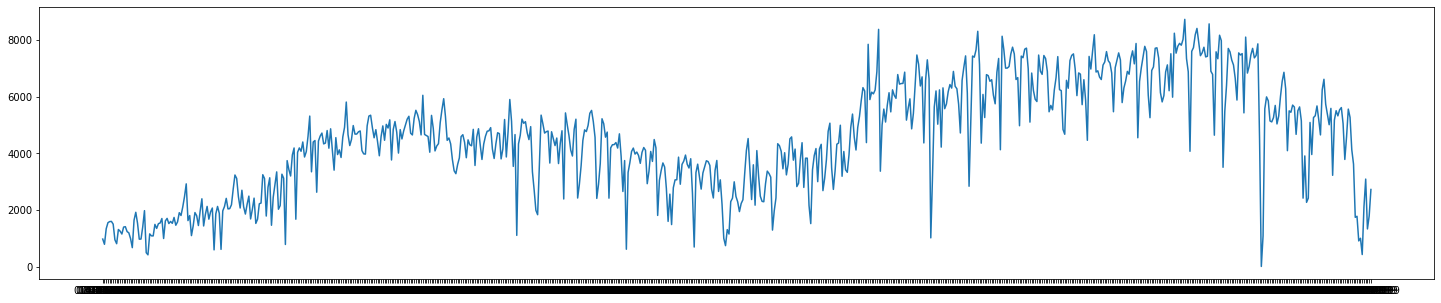

In [7]:
# Just viewing the general trend by Time
plt.figure(figsize = [25,5])
plt.plot(bikes['dteday'], bikes['cnt'])
# plt.xticks(rotation = 45)
plt.show()

###  Understand the Data Dictionary

The following are the data given in the dataset:
    - instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

Based on the initial understanding of the data, the instant variable and the date variable can be dropped as
1. the instant variable is just an index for the rows
2. We are not doing a time series analysis and hence date column is not required with its unique number of 365 *2 variable

## Step 2: Data Cleansing and Treatment

### Drop Unnecessary Columns

In [8]:
bikes.drop(['instant','dteday'], axis=1, inplace=True)

In [9]:
bikes.head(1)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985


From the original data dictionary, I also note that `casual` and `registered` columns add up to the target variable `cnt`. Let us verify if that is indeed true

In [10]:
bikes['calc_count'] = bikes['casual'] + bikes['registered']

In [11]:
(bikes['calc_count'] - bikes['cnt']).sum()

0

Since `casual` and `registered` add up to `cnt`, clearly they are in a way, **Target** variables themselves and hence do not want to consider them as features for the analysis.
Will drop them along with the newly calculated count column

In [12]:
bikes.drop(['casual','registered','calc_count'], axis = 1, inplace = True)

In [13]:
bikes.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


### Clean the data

#### Inspect for null values

In [14]:
bikes.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

There are no nulls in the data and hence no treatment of nulls required

### Understand and Transform the categorical variables

In [15]:
# Prelimanry check of values and their counts in season
bikes['season'].value_counts()

3    188
2    184
1    180
4    178
Name: season, dtype: int64

Would like to convert he seasons into meaningful names so that the analysis will be better understood and presentable

In [16]:
bikes['season'] = bikes['season'].map({1:'spring',2:'summer',3:'fall',4:'winter'})

In [17]:
# validate that the season has been converted correctly into a category
bikes['season'].value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

Similarly, convert the `yr`, `mnth`, `weekday` and `weathersit` variables

In [18]:
# Prelimanry check of values and their counts in year
bikes['yr'].value_counts()

1    365
0    365
Name: yr, dtype: int64

In [19]:
bikes['yr'] = bikes['yr'].map({0: '2018',1: '2019'})

In [20]:
# validate that the year has been converted correctly into a category
bikes['yr'].value_counts()

2019    365
2018    365
Name: yr, dtype: int64

In [21]:
# Prelimanry check of values and their counts in month
bikes['mnth'].value_counts()

12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     56
Name: mnth, dtype: int64

In [22]:
bikes['mnth'] = bikes['mnth'].map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'jun',7:'jul',8:'aug',9:'sep',10:'oct'
                                  ,11:'nov',12:'dec'})

In [23]:
# validate that the mnth has been converted correctly into a category
bikes['mnth'].value_counts()

mar    62
may    62
jul    62
oct    62
jan    62
dec    62
aug    62
jun    60
nov    60
apr    60
sep    60
feb    56
Name: mnth, dtype: int64

In [24]:
# Prelimanry check of values and their counts in weekday
bikes['weekday'].value_counts()

6    105
1    105
0    105
5    104
4    104
2    104
3    103
Name: weekday, dtype: int64

From a logical analysis of dates, weekday, holiday and working day, i realised this data is clearly not mapping to the 2018 calendar but to some other year. And 0 maps to Sunday, 6 maps to Satuday. 
Hence the below mapping has been chartered

In [25]:
bikes['weekday'] = bikes['weekday'].map({0:'sunday',1:'monday',2:'tuesday',3:'wednesday',4:'thursday',5:'friday',
                                         6:'saturday'})

In [26]:
# validate that the weekday has been converted correctly into a category
bikes['weekday'].value_counts()

saturday     105
sunday       105
monday       105
thursday     104
tuesday      104
friday       104
wednesday    103
Name: weekday, dtype: int64

In [27]:
# Prelimanry check of values and their counts in weathersit
bikes['weathersit'].value_counts()

1    463
2    246
3     21
Name: weathersit, dtype: int64

In [28]:
bikes['weathersit'] = bikes['weathersit'].map({1:'clear',2:'mist',3:'light',4:'heavy'})

In [29]:
# validate that the weathersit has been converted correctly into a category
bikes['weathersit'].value_counts()

clear    463
mist     246
light     21
Name: weathersit, dtype: int64

Observation: It seems like no heavy weather conditions have been noticed in this area in the year 2018 and 2019

#### Now view the sample data to see all the categorical variables converted into meaning full names

In [30]:
bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,2018,jan,0,saturday,0,mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,2018,jan,0,sunday,0,mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,2018,jan,0,monday,1,clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,2018,jan,0,tuesday,1,clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,2018,jan,0,wednesday,1,clear,9.305237,11.46350,43.6957,12.522300,1600


### Check for outliers

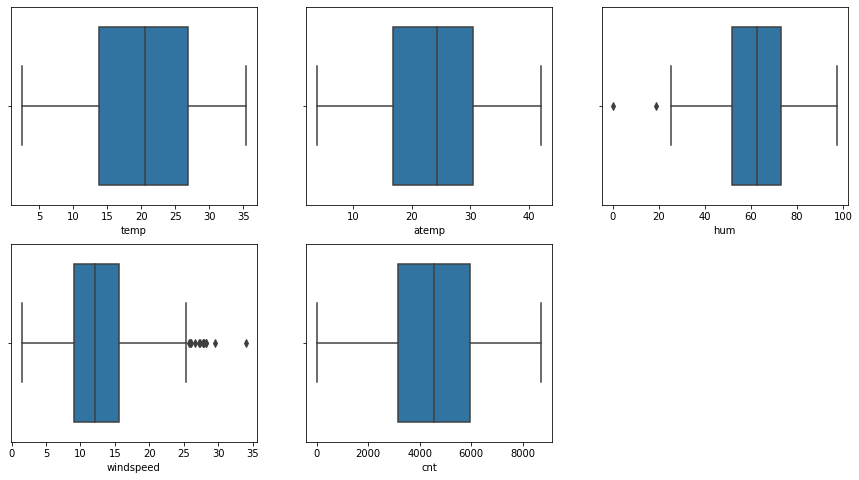

In [31]:
cont_vars = ['temp','atemp','hum','windspeed','cnt']

plt.figure(figsize = [15,8])
i = 1
for var in cont_vars:
    plt.subplot(2,3,i)
    sns.boxplot(bikes[var])
    i += 1
    
plt.show()

In [32]:
bikes[cont_vars].describe()

,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000
mean,20.319259,23.726322,62.765175,12.763620,4508.006849
std,7.506729,8.150308,14.237589,5.195841,1936.011647
min,2.424346,3.953480,0.000000,1.500244,22.000000
25%,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,26.880615,30.445775,72.989575,15.625589,5966.000000
max,35.328347,42.044800,97.250000,34.000021,8714.000000


**Conclusion:**
There are not any very significant outliers and hence no treatment s done

## Step 3: Exploratory Data Analysis

### Univariate Analysis

#### For Categorical Variables

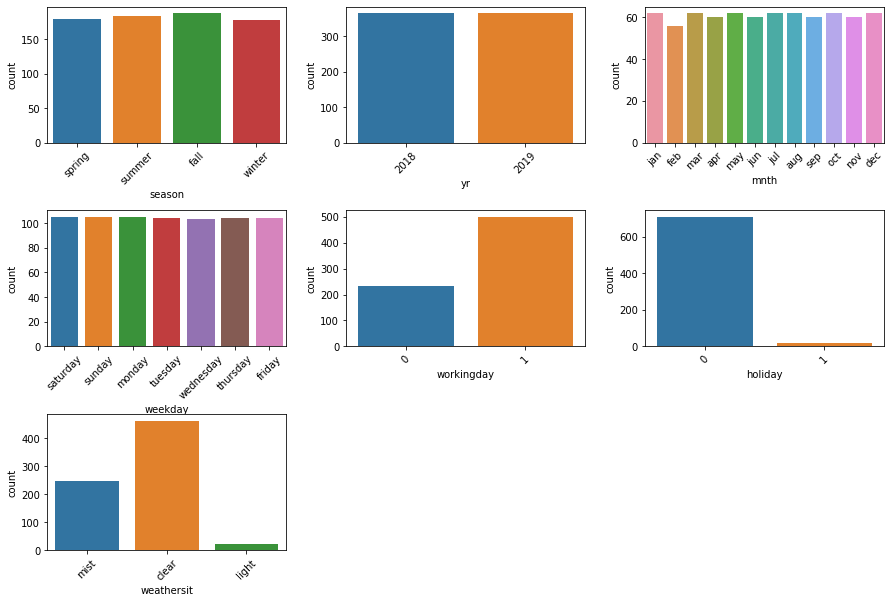

In [33]:
cat_vars = ['season','yr','mnth','weekday','workingday','holiday','weathersit']

plt.figure(figsize=[15, 10])
plt.subplots_adjust(hspace=0.50,wspace=0.25)
for i,var in enumerate(cat_vars):
    plt.subplot(3,3,i+1)
    sns.countplot(bikes[var])
    plt.xticks(rotation=45)
plt.show()

This is not a very useful plot as the number of days in the seasons, the yeards, the months and the weeks are all predefined and almost equal. 
The only insights as expected, is 
1. that the number of working days are much larger than non-working days, 
2. the number of holidays is very small and 
3. the number of days with clear weather is much larger than the other 2 categories. The number of misty days is nearly half of clear days and number of light rain rays are very small. There are no days with heavy rain at all

### For Continuous variables

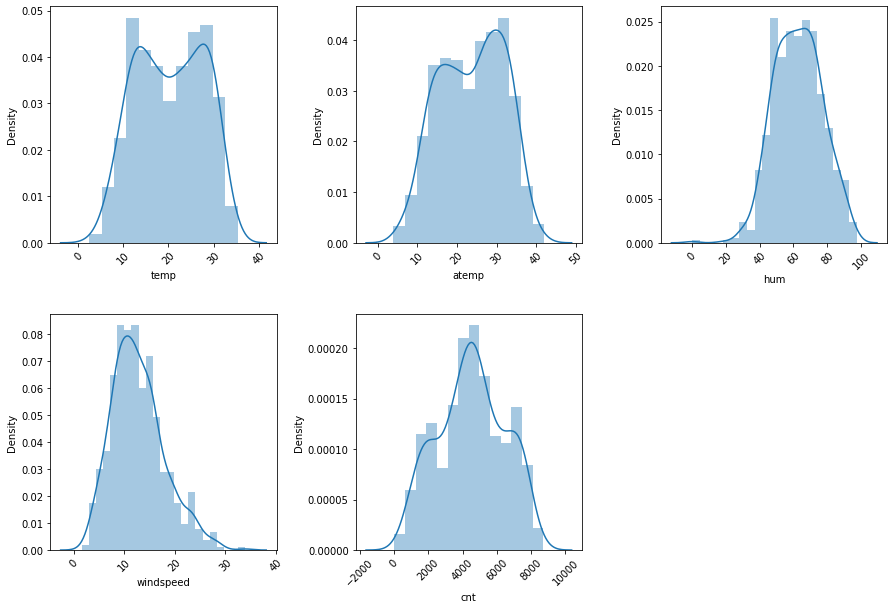

In [34]:
cont_vars = ['temp','atemp','hum','windspeed','cnt']

plt.figure(figsize=[15,10])
plt.subplots_adjust(hspace=0.30,wspace=0.35)
for i,col in enumerate(cont_vars):
    plt.subplot(2,3,i+1)
    sns.distplot(bikes[col],hist=True)
    plt.xticks(rotation=45)
    plt.ylabel("Density")
    
plt.show()

### Bivariate Analysis

#### Continuous-continuous variables

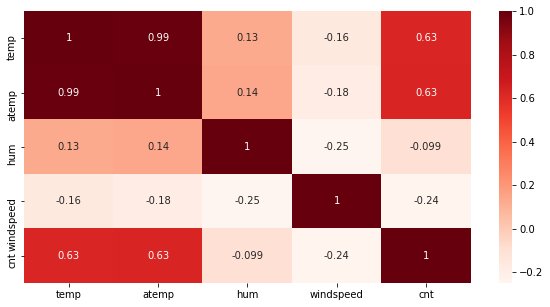

In [35]:
cont_vars = ['temp','atemp','hum','windspeed','cnt']
plt.figure(figsize = [10, 5])
sns.heatmap(bikes[cont_vars].corr(),annot=True, cmap='Reds')

plt.show()

**Conclusions:**
1. `temp` and `atemp` are extremely coorelated and hence only one of them is required. However, keeping this in mind, I will see how the model will help in eliminating one of them
2. `cnt` is positively corelated to temp and negatively corelated with windspeed and humidity, as one can expect

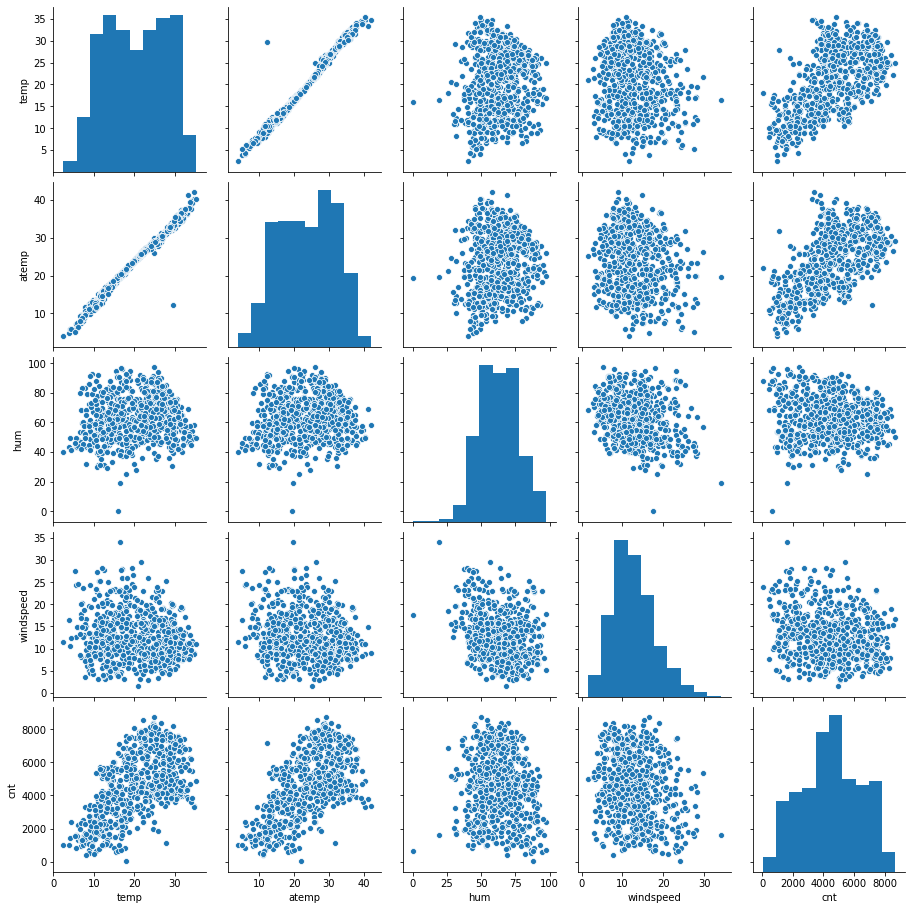

In [36]:
# Now let us visualise using a pairplot
cont_vars = ['temp','atemp','hum','windspeed','cnt']
sns.pairplot(data=bikes, vars = cont_vars)
plt.show()

**Conclusions:**
1. Similar conclusions as in the heatmap
2. You can also notice that there are not very visible outliers in the data 
3. You also notice that the temp and atemp variables are highly corelated and one of them can be dropped. However, in order to decide which is more useful, I will keep it and let the model decide to drop one of them

#### Categorical-Numerical Variables

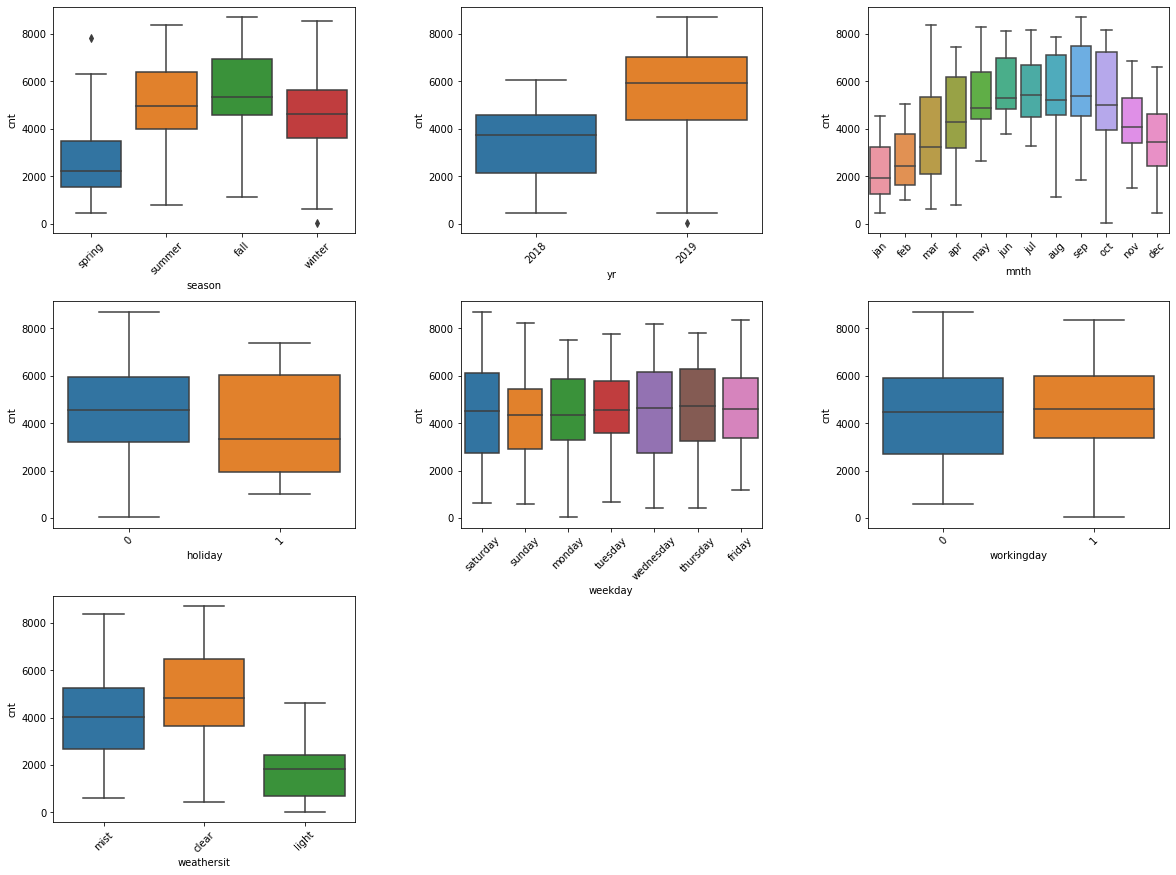

In [37]:
plt.figure(figsize=[20,15])

cat_vars = ['season','yr','mnth','holiday','weekday','workingday','weathersit']

# sns.boxplot(x='season', y = 'cnt', data=bikes)
plt.subplots_adjust(hspace=0.30,wspace=0.35)
for i,col in enumerate(cat_vars):
    plt.subplot(3,3,i+1)
    sns.boxplot(x = col, y = 'cnt', data = bikes)
    plt.xticks(rotation=45)
    
plt.show()

Observations:

1. Summer and Fall see a much higher usage than Spring. Winter is in between. The spread by months also seems to reflect the same. The fall months of 8, 9 and 10 see the highest usage
2. The growth in the 2nd year is significant compared to the 1st year. 
3. The median of usage on a non-holiday seems higher than holidays. The spread is larger on Holidays.
4. The median usage on all days of the week is very similar with the spreads varying a little
5. Also as expected, weather plays a role in the usage of bikes. Even light rain brings down the usage drastically. Clear weather sees the maximum usage and mist sees a mild drop

## Step 3: Data Preparation for Modelling 

### Create Dummy variables for multi-level categorical variables

1. For all the categorical variables with multiple levels like:
    - season
    - mnth
    - weekday
    - weathersit
    - yr
    
    need to create dummy variable with n-1 columns representing them.
    
2. For the binary categorical variables like
    - holiday
    - workingday
    there is no need of any change as they are binary. already

In [38]:
# create dummy variables for the categorical variables, required
dum_cat_vars = ['season','mnth','weekday','weathersit','yr']

for var in dum_cat_vars:
    temp_var = pd.get_dummies(bikes[var], drop_first = True)
    bikes = pd.concat([bikes, temp_var], axis = 1)
    bikes.drop(var, axis=1, inplace = True)
    
bikes.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,light,mist,2019
0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [39]:
bikes.shape

(730, 30)

### Split the Data in Train and Test Sets

In [40]:
np.random.seed(0)
bikes_train, bikes_test = train_test_split(bikes, train_size = 0.7, random_state = 100)

In [41]:
print(bikes_train.shape)
print(bikes_test.shape)

(510, 30)
(220, 30)


### Rescale the features

We will scale the non categorical variables using MinMaxScaler

In [42]:
scaler = MinMaxScaler()

In [43]:
# Apply scaler() to all the columns except the 'binary' columns and 'dummy' variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']

bikes_train[num_vars] = scaler.fit_transform(bikes_train[num_vars])

In [44]:
bikes_train.head()

,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,winter,aug,dec,feb,jan,jul,jun,mar,may,nov,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,light,mist,2019
576,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
426,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1
728,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
482,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1
111,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### Dividing into X and Y sets for the model building

In [45]:
y_train = bikes_train.pop('cnt')
X_train = bikes_train

## Step 4: Build the Model

Since there are 30 features, we will use a "balanced" approach:
1. Will reduce the number of variables to 15 through RFE (Recursive Feature Selection)
2. Then, will use the backward approach to lead to the final set of variables with significant coefficients

### RFE

In [46]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [47]:
rfe = RFE(lm,15)
rfe.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [48]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 6),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', True, 1),
 ('winter', True, 1),
 ('aug', False, 8),
 ('dec', False, 3),
 ('feb', False, 4),
 ('jan', True, 1),
 ('jul', True, 1),
 ('jun', False, 13),
 ('mar', False, 15),
 ('may', False, 7),
 ('nov', False, 2),
 ('oct', False, 14),
 ('sep', True, 1),
 ('monday', False, 9),
 ('saturday', True, 1),
 ('sunday', False, 5),
 ('thursday', False, 11),
 ('tuesday', False, 10),
 ('wednesday', False, 12),
 ('light', True, 1),
 ('mist', True, 1),
 ('2019', True, 1)]

In [49]:
# Select the 15 columns that RFE hsa provided as the shirtlisted ones
col = X_train.columns[rfe.support_]
col

Index(['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring', 'summer',
       'winter', 'jan', 'jul', 'sep', 'saturday', 'light', 'mist', '2019'],
      dtype='object')

### Building model using statsmodel to get stats

In [50]:
X_train_rfe = X_train[col]

In [51]:
# Adding a constant variable 
X_train_lm = sm.add_constant(X_train_rfe)

In [52]:
# Create model 1
lm_1 = sm.OLS(y_train,X_train_lm).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Sun, 06 Dec 2020   Prob (F-statistic):          4.22e-191
Time:                        13:21:33   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2519      0.036      6.969      0.0

In [53]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_rfe
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,29.37
2,temp,17.78
1,workingday,5.31
4,windspeed,4.73
5,spring,4.53
7,winter,3.46
6,summer,2.85
13,mist,2.29
14,2019,2.09
11,saturday,1.98


In [54]:
# Since "jan" has high a high p-value, will drop that and rerun the model
X_train_new = X_train_rfe.drop(["jan"], axis = 1)

In [55]:
# Adding a constant variable  
X_train_lm = sm.add_constant(X_train_new)

#create model 2
lm_2 = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm_2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Sun, 06 Dec 2020   Prob (F-statistic):          2.11e-191
Time:                        13:21:36   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2402      0.036      6.714      0.0

In [56]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,hum,28.46
2,temp,16.98
1,workingday,5.28
4,windspeed,4.72
5,spring,4.24
7,winter,3.42
6,summer,2.85
12,mist,2.29
13,2019,2.08
10,saturday,1.97


In [57]:
# Since holiday has a high p-value, will drop it now
X_train_new = X_train_new.drop(["holiday"], axis = 1)

In [58]:
# Adding a constant variable  
X_train_lm = sm.add_constant(X_train_new)

#Create model 3
lm_3 = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm_3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     208.8
Date:                Sun, 06 Dec 2020   Prob (F-statistic):          1.54e-191
Time:                        13:21:38   Log-Likelihood:                 515.15
No. Observations:                 510   AIC:                            -1002.
Df Residuals:                     496   BIC:                            -943.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2307      0.036      6.472      0.0

In [59]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,hum,28.38
1,temp,16.88
0,workingday,4.72
3,windspeed,4.70
4,spring,4.18
6,winter,3.39
5,summer,2.84
11,mist,2.28
12,2019,2.08
9,saturday,1.84


In [60]:
# Since spring has a high p-value, will drop it now
X_train_new = X_train_new.drop(["spring"], axis = 1)

In [61]:
# Adding a constant variable  
X_train_lm = sm.add_constant(X_train_new)

# Create Model 4
lm_4 = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm_4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     222.7
Date:                Sun, 06 Dec 2020   Prob (F-statistic):          4.14e-191
Time:                        13:21:41   Log-Likelihood:                 511.32
No. Observations:                 510   AIC:                            -996.6
Df Residuals:                     497   BIC:                            -941.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1712      0.028      6.014      0.0

In [62]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,hum,16.21
1,temp,10.36
0,workingday,4.54
3,windspeed,3.73
10,mist,2.10
11,2019,2.03
8,saturday,1.79
4,summer,1.76
5,winter,1.70
6,jul,1.55


In [63]:
# Since july has a high p-value, will drop it now
X_train_new = X_train_new.drop(["jul"], axis = 1)

In [64]:
# Adding a constant variable  
X_train_lm = sm.add_constant(X_train_new)

# Create model 5
lm_5 = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm_5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     240.0
Date:                Sun, 06 Dec 2020   Prob (F-statistic):          5.10e-191
Time:                        13:21:44   Log-Likelihood:                 508.25
No. Observations:                 510   AIC:                            -992.5
Df Residuals:                     498   BIC:                            -941.7
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1705      0.029      5.960      0.0

In [65]:
# Calculate the VIFs for the model
vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,hum,15.96
1,temp,8.12
0,workingday,4.53
3,windspeed,3.73
9,mist,2.10
10,2019,2.02
7,saturday,1.79
5,winter,1.66
4,summer,1.58
6,sep,1.20


In [66]:
# Humidity still has a high VIF though a low p-value. hence will drop it
X_train_new = X_train_new.drop(['hum'], axis=1)

In [67]:
X_train_lm = sm.add_constant(X_train_new)

# Create model 6
lm_6 = sm.OLS(y_train,X_train_lm).fit()   # Running the linear model
print(lm_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     253.0
Date:                Sun, 06 Dec 2020   Prob (F-statistic):          3.13e-188
Time:                        13:21:46   Log-Likelihood:                 498.79
No. Observations:                 510   AIC:                            -975.6
Df Residuals:                     499   BIC:                            -929.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0750      0.019      4.031      0.0

In [68]:
# Calculate the VIFs for the new model

vif = pd.DataFrame()
X = X_train_new
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,temp,4.76
0,workingday,4.04
2,windspeed,3.44
9,2019,2.02
6,saturday,1.69
3,summer,1.57
8,mist,1.53
4,winter,1.40
5,sep,1.20
7,light,1.08


## Step 5: Validate the assumptions

### Residual Analysis of the Train Data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [69]:
y_train_cnt = lm_6.predict(X_train_lm)

Text(0.5, 0, 'Errors')

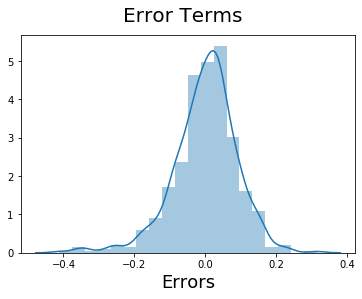

In [70]:
# Plot the histogram of the error terms
fig = plt.figure()
residual = y_train - y_train_cnt
sns.distplot(residual, bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label

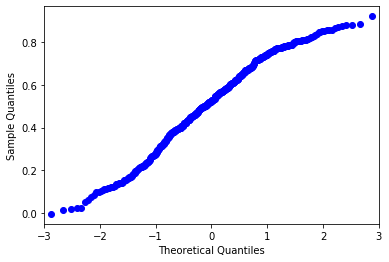

In [71]:
# data_points = np.random.normal(0, 1, 100)     
import pylab as py
sm.qqplot(y_train_cnt) 
py.show() 

QQ Plots are used to assess if residuals are normally distributed. Basically what we are looking for here is the data points closely follow the straight line at a 45% angle upwards (left to right). and that is indeed the case here and hence error is normally distributed

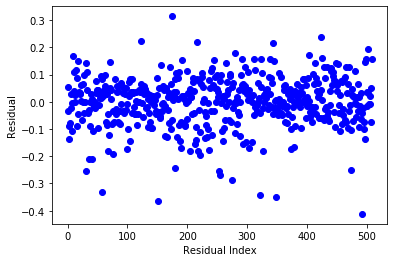

In [72]:
residual = y_train - y_train_cnt
res_df = pd.DataFrame({'index':residual.index, 'res':residual.values})
plt.plot(res_df.index, res_df.res, 'bo')
plt.xlabel('Residual Index')
plt.ylabel('Residual')
plt.show()

You can see that the residuals are completely random and they are independent of each other. there is no pattern visible in the error distribution. The independence of the errors is stablished this way.

## Step 6: Making Predictions

### Apply the scaling on the test set

In [73]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']

bikes_test[num_vars] = scaler.transform(bikes_test[num_vars])

### Divide into X_test and y_test

In [74]:
y_test = bikes_test.pop('cnt')
X_test = bikes_test

In [75]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train_new.columns]

# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

# Making predictions
y_pred = lm_6.predict(X_test_new)

### Model Evaluation

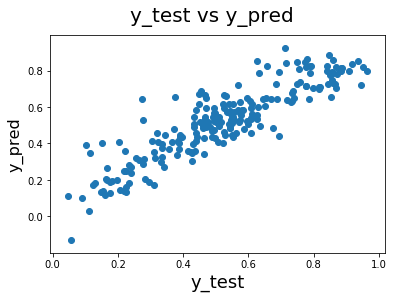

In [76]:
# Plotting y_test and y_pred to understand the spread.
fig = plt.figure()
plt.scatter(y_test,y_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16) 
plt.show()

In [77]:
r2_score(y_test, y_pred)

0.7961390438459766

**Conclusion:**

Since the R2 score of test data is close to 80% while that of train data in around 83.5%, this seems like an acceptable model

The model coefficients are as shown below:

In [78]:
print(lm_6.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     253.0
Date:                Sun, 06 Dec 2020   Prob (F-statistic):          3.13e-188
Time:                        13:22:09   Log-Likelihood:                 498.79
No. Observations:                 510   AIC:                            -975.6
Df Residuals:                     499   BIC:                            -929.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0750      0.019      4.031      0.0

This implies that all the coefficients are significant as p-value os 0 for all of them
The R-squared avlue is 83.5%
The Adjusted r-squared is a very close 83.2%

The r2_score of the test data is also coming close to 80% and hence is an acceptable model

**Interpretation:**
1. The highest influence on count is by temperature. For even unit temperature rise, the count increases by 0.5499
2. Light rain, mist and windspeed are negatively influencing the count. For every unit increase in these 3 variables, there is a decrease of 0.2871, 0.0800 and 0.1552 units in count
3. THe next positively correlated variable is year 2019. Meaning that by the 2nd year, the counts had increased by 0.2331 
4. A working day causes an increase in count by 0.0561 units
5. With none of these variables influencing, the bare minimum count will be as shown by the constant/intercept - 0.0750
6. Summer, winter seem to also cause a count increase. 
7. By earlier graphs, we see that Fall also has the highest count. This is probaby shown in this model by the positive correlation in the month of spetember which see the highest influence on the count - by months
8. Likewise, daturday seems to have a signifiant influence in the count


So our model euqation is:

***cnt = 0.0750 + (00561 * workingday) + (0.5499 * temp) + (-0.1552 * windspeed) + (0.0886 * summer) + (0.1307 * winter) + (0.0974 * sep) + (0.0675 * saturday) + (-0.2871 * light) + (-0.0800 * mist) + (0.2331 * yr)***

### Top 3 contributers
And from the above, we can see that temperature has the highest contribution in explaining the demand for bikes. With every unit increase in temperature, the demand goes up by 0.55 units. 

Light rain as the highest negative contribution to the demand. With every unit of light rain increase, there is decrease in demand by 0.29 units. 

The 3rd contributing element is the year 2019. This just means that there is a natural growth from year on year. From 2018 to 2019, there was a growth of 0.2331 units and hence if all conditions remains same, the next year growth can take this unit of growth for granted.